# Machine Learning in Python - Project 2

Due Friday, April 9th by 5 pm UK local time.

Beumers Roel, Gvero Tom, Zielinski Maciej

## 0. Setup

In [ ]:
# Install required packages
!pip install -q -r requirements.txt

In [ ]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# customize color palette
custom_palette = ['#003f5c', '#ffa600', '#f95d6a', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600'] 
sns.set_palette(custom_palette)

# surpress some errors for the final version of the report
import warnings
warnings.filterwarnings("ignore")

# sklearn modules
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler

## 1. Introduction


People tend to make their plans and the corresponding reservations well in advance. Since the lead time can be as long as a couple of months this should allow for hotel management to adjust their operations accordingly. However, this is often not a case. While people book their hotel rooms in advance they might cancel a few days before their reservation, which then causes hotels to lose their revenue. This is why prediction of customers more likely to cancel their bookings is so vital. We hope that our report will help hotel management make more informed decisions with regards to safeguarding against this lost revenue.

In this report we will be examining a dataset collected by Antonio et al. (2019) detailing booking information for two hotels. We aim to model the trends in this data in order to advise a large hotel operator on why customers cancel their bookings. 

The dataset contains various details about each booking, including both details about the customers themselves and the nature of their booking - things like special requests, deposit type etc. We begin with exploratory data analysis. Here, we start by cleaning the data, dealing with any missing values and disregarding any observations or variables which are clearly erroneous. Then we look for relationships between our variables in order to decide which ones will be most important when it comes to modelling and predicting a cancellation. These key variables can then be feature engineered to prepare them for the modelling process.

We then move onto modelling, starting with a logisitic regression model to use as a baseline. Building on this, we explore decision trees and further, random forests, in order to try and provide some concrete advice on what the key features are of a booking that is likely to be cancelled.

## 2. Exploratory Data Analysis and Feature Engineering

In order to construct the appropriate model to predict cancellations, one has to explore the available data first. In this section, we first check for the missing values in the data as this can have a severe effect on the following analysis and then we investigate the key features of the data that will be relevant to the subsequent modelling. 

In [ ]:
# Load data
d = pd.read_csv("hotel.csv")

### 2.1 Checking for the missing values

The dataset does contain missing data for four variables: company, agent, country and children. However, the hotel property management systems (PMS) assured that there are no missing data in this database (Antonio et al., 2019). Therefore, the missing values found by us are not supposed to be considered missing but rather "not applicable" (ibid.). Based on the article, we know that for the case of an agent the missing value translates to the booking not coming from the travel agent but rather the booking being made by an individual. A similar situation happens with the variable company - missing values translate to "not applicable", which means that the entity that made the booking or is responsible for paying the booking is not a company. However, since there were 94% of data in "not applicable" category we have decided to drop that variable due to limited predictive power.

Given that there were only four missing values in the "children" column, we decided to use mode imputation to fill these - the mode happens to be zero. We believe that the most likely reason for missingness of that variable is due to a lack of attention of person making the booking. It is also very likely that lack of information for that variable is equivalent to no children at the reservation. In any case, we feel mode imputation is an appropriate action. 

Finally, missing values for the variable "country" will be imputed with the mode, i.e. Portugal. There is however an important point to make about this particular variable. As noted by Antonio et al. (2019), it is very common for hotels not to know the guests' nationality until the moment of check-in and hence, it is important to be cautious when using this feature. It does seems logical that Portugal would be the source of most of these unknown cases given that the hotels themselves are in Portugal so guests booking through local sources may not deem it relevant to declare their nationality. Even so, only 488 of these values are missing so this does not have a significant impact on the data as a whole.


In [ ]:
#deal with na values as described above
d.children.fillna(0, inplace = True)
d.country.fillna(d.country.mode(), inplace = True)
d.agent.fillna("Not Applicable", inplace = True)
d.drop("company", axis = 1, inplace = True)

### 2.2 Checking for discrepancies in the data

We explored the dataset checking whether filled in values correspond to the data description and looking for possible outliers or values that do not make sense. We have identified a few instances of such data discrepancies and will provide a detailed description below.

#### 2.2.1 Questionable number of people on a booking

We have identified reservations for which there are babies or children with no adults. We believe this to be unreasonable for babies or children to make bookings without parental supervision and therefore decided to drop these values. Hence, we dropped 226 rows where there were no adults present on the reservation. 

What we found to be even more suspicious were the reservations for no guests at all. This has happened 180 times throughout the dataset.

This can be due to the aforementioned problem in the hotel industry, i.e. the correct information about the reservation can only be captured once guests check-in. Nevertheless, we have decided to drop these records.

In [ ]:
# no adults, no children, no babies
print("nobody on reservation: ", d[d.adults + d.children + d.babies == 0]["adults"].count())
# babies but no adults
print("babies with no adults: ", d[(d.adults == 0) & (d.babies > 0)]["babies"].count())
# children but no adults
print("children with no adults: ", d[(d.adults == 0) & (d.children > 0)]["children"].count())

# drop the unnecessary values and columns
d.drop(d[(d.adults == 0)].index, inplace = True)
d.drop("children", axis = 1, inplace = True)
d.drop("babies", axis = 1, inplace = True)

nobody on reservation:  180
babies with no adults:  3
children with no adults:  223


#### 2.2.2 Questionable values of Average Daily Rate

Having investigated the average daily rate variable "adr" we found that the vast majority of values lie between 0 and 300 with the mean of 102. There are, however, two values worth mentioning: one is a negative adr and the other a possible outlier. According to the data description, the adr is defined by dividing the sum of all lodging transactions by the total number of staying nights. Therefore, it makes no sense for the adr to be negative. The other worrying value is 5400 which is a very possible outlier. We considered both values to be anomalies and dropped them. 

number of negative adr:  1


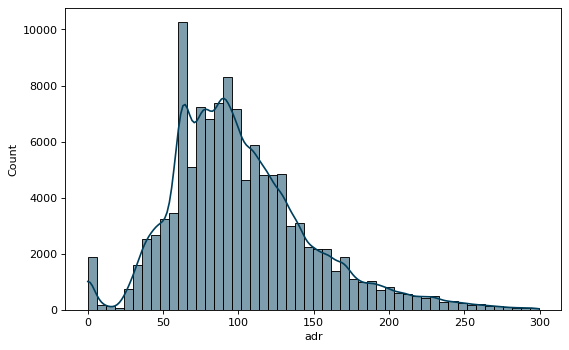

adr mean is:  102.00898677155294
adr max is:  5400.0


In [ ]:
# there's a negative adr
print("number of negative adr: ", d[d.adr < 0]["adr"].count())

# drop unncessary values
d.drop(d[(d.adr < 0)].index, inplace = True)

# histogram of adr
sns.histplot(d[d.adr < 300]["adr"], bins=50, kde = True)
plt.show()

# calculation of mean and max of adr
print("adr mean is: ", d.adr.mean())
print("adr max is: ", d.adr.max()) # but according to the histogram MOST values are way lower - i.e. possible outlier

#### 2.2.3 Questionable number of nights on a booking

Using variables for the number of week and weekend nights we found that there are bookings in data consisting of zero nights. This has become apparent in the data for 645 times. Therefore, we decided to drop rows containing this questionable result. We also checked whether the booking for more than two weekend nights also consists of at least five week nights. Luckily, this assumption holds for every row in our data.


In [ ]:
# reservations for zero nights
print("people staying for zero nights: ", d[(d.stays_in_weekend_nights == 0) & (d.stays_in_week_nights == 0)]["stays_in_week_nights"].count())

# check if all reservations for more than two weekend nights imply reservation for at least five week nights
print("people staying for more than two weekend nigths but less than five week nights: ", d[(d.stays_in_weekend_nights > 2) & (d.stays_in_week_nights < 5)]["stays_in_week_nights"].count())

# drop the unncessary values
d.drop(d[(d.stays_in_weekend_nights == 0) & (d.stays_in_week_nights == 0)].index, inplace = True)

### 2.3 Overview of the data and feature engineering

We will now explore relationships between our features and the outcome variable in order to decide which variables will be relevant when it comes to the modelling stage and which variables we can disregard to simplify our model. We can then carry out feature engineering to prepare these chosen variables for use as part of the models we have decided to test.

#### 2.3.1 The outcome variable: is_canceled

This is a binary variable indicating whether the booking was cancelled (1) or not cancelled (0). Based on the plot below we can see that the majority of bookings were not cancelled.

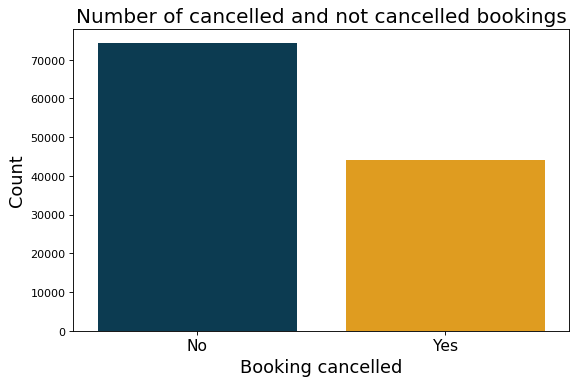

In [ ]:
sns.countplot("is_canceled", data=d)
plt.title("Number of cancelled and not cancelled bookings", fontsize = 18)
plt.xlabel("Booking cancelled", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(ticks = [0,1], labels = ["No", "Yes"], fontsize = 14)
plt.show()

#### 2.3.2 Examining the relationship between the country of origin and cancelled bookings

The top five countries of origin of clients were Portugal, Great Britain, France, Spain and Germany. On the plot below we have shown how Portugal compares to other top five countries in terms of total number of bookings. About 40% of all reservations were made locally from Portugal. Interestingly, after a closer investigation we found out that if the reservation was made by a person from Portugal it was more likely to be cancelled. The relationship is depicted on the right-hand side plot. We believe that this is plausible as people making bookings from other countries are likely to be bearing the costs of plane tickes as well as hotel reservation. On the other hand, when a reservation is being made locally the only sunk costs are the cost of accomodation and cost of car journey to the hotel which we assumed to be smaller than the cost of a flight. Therefore, we have decided to create a feature capturing the effect of the country of origin being Portugal. It is a dummy variable "is_portugal" that is 1 if the country is Portugal or 0 otherwise.

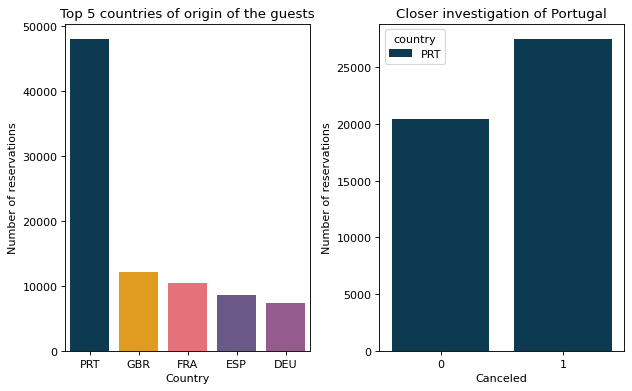

In [ ]:
# plotting two graphs side by side
fig, axes = plt.subplots(1,2)

# the first plot represents top five countries of origin of hotel guests
sns.countplot(x="country", data=d, order=pd.value_counts(d["country"]).iloc[:5].index,
        ax = axes[0]).set(title = "Top 5 countries of origin of the guests", xlabel = "Country", ylabel = "Number of reservations")

# the second plot compares number of reservations canceled and not canceled for Portugal
sns.countplot("is_canceled", hue="country", data = d[d.country == "PRT"],
        ax = axes[1]).set(title = "Closer investigation of Portugal", xlabel = "Canceled", ylabel = "Number of reservations")
plt.tight_layout()
plt.show()

# create a dummy variable if the country of origin is Portugal
d["is_portugal"] = np.where(d.country == "PRT", 1, 0)

#### 2.3.3 Examining the relationship between the lead time and cancelled bookings

Looking at the below boxplots we can see that there appears to be a distinct difference in distributions of the lead time, depending on if an individual cancelled or not. It appears that a longer lead times is correlated with a higher likelihood of cancelling. Logically this makes sense because the further in advance that someone books a holiday, the more likely it is that something will occur in the time between the booking and the holiday that means they are no longer able to attend and thus must cancel. This is something that we would like to explore further by including this variable in our modelling. 

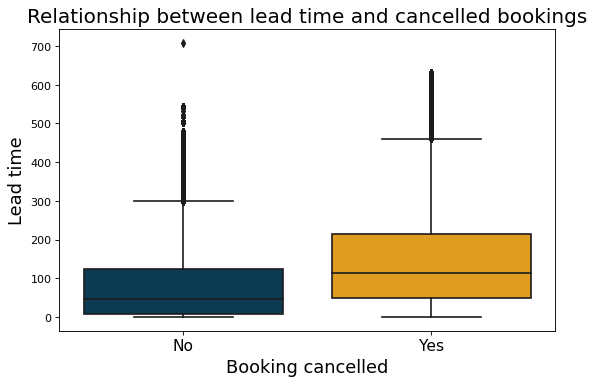

In [ ]:
sns.boxplot("is_canceled","lead_time",data = d)
plt.title("Relationship between lead time and cancelled bookings", fontsize = 18)
plt.xlabel("Booking cancelled", fontsize=16)
plt.ylabel("Lead time", fontsize=16)
plt.xticks(ticks = [0,1], labels = ["No", "Yes"], fontsize = 14)
plt.show()

#### 2.3.4 Examining the relationship between types of meals booked and cancelled bookings

What we see from the first bar chart below is that in every meal class people cancel less often than not with the exception of full board. Here, more people actually cancel. To investigate this further we will create a new binary variable "full_board", with a value of 1 if someone is full board and 0 if they are not. We then plot a similar bar chart to see the effect. We see that although the sample size for full board customers is small, there is a significant difference in the distribution of cancellations between the two groups. This is something we could look at in modelling. 

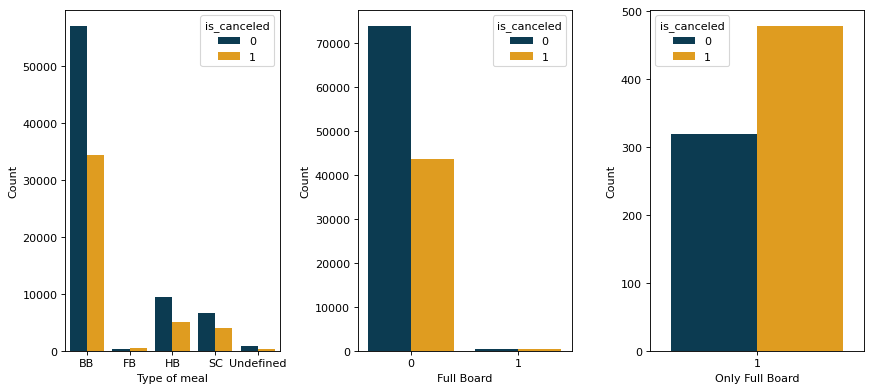

In [ ]:
#add binary column to indicate if someone is full board or not
d["full_board"] = np.where(d["meal"]=="FB",1,0)

# plotting three graphs side by side
fig, axes = plt.subplots(1,3, figsize = (11,5))

# the first plot 
sns.countplot("meal", hue = "is_canceled", data = d,
        ax = axes[0]).set(xlabel = "Type of meal", ylabel = "Count")

# the second plot
sns.countplot("full_board", hue="is_canceled", data=d,
        ax = axes[1]).set(xlabel = "Full Board", ylabel = "Count")

# the third plot 
sns.countplot("full_board", hue="is_canceled", data=d[d.full_board == 1],
        ax=axes[2]).set(xlabel = "Only Full Board", ylabel = "Count")
plt.tight_layout()
plt.show()

#### 2.3.5 Examining the relationship between previous reservations and cancelled bookings

We anticipate that a customers cancellation history would have reasonable bearing on their propensity to cancel again in the future. Here, we are not so interested in the number of previous cancellations, but instead, we have created a new binary column for if someone has any previous cancellations - 1 if they do, 0 if they don't. You can see that people who have cancelled are proportionaly a lot more likely to cancel again than those who haven't. Again, the instances of previous cancellers are few and far between, although such a stark change in cancellation distribution warrants inclusion in our model. Likewise, people who have booked and stayed at the hotel before are less likely to cancel than those who haven't, so we have created a corresponding binary varible in the same form as the one we made for previous cancellations.

There are  6473  people with previous cancellations.


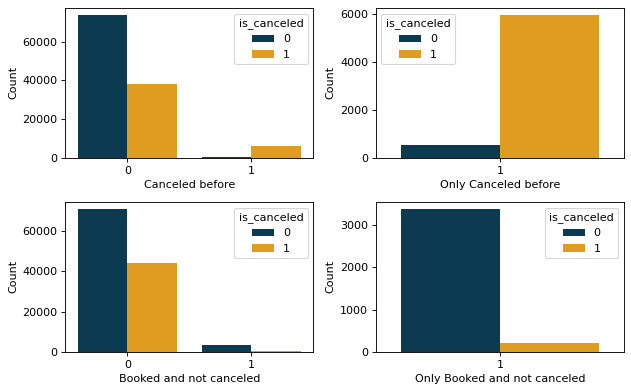

In [ ]:
# count how many people have previously canceled their reservations
print("There are ",d[d.previous_cancellations > 0]["previous_cancellations"].count(), " people with previous cancellations.")

# creating dummy variables 
d["previous"] = np.where(d["previous_cancellations"]>0,1,0) ## maybe try to find a better name for this feature?
d["previously_booked"] = np.where(d["previous_bookings_not_canceled"]>0,1,0)

# plotting graphs side by side
fig, axes = plt.subplots(2,2)

# the first plot 
sns.countplot("previous",hue="is_canceled",data=d,
        ax = axes[0,0]).set(xlabel = "Canceled before", ylabel = "Count")

# the second plot 
sns.countplot("previous",hue="is_canceled",data=d[d.previous == 1],
        ax = axes[0,1]).set(xlabel = "Only Canceled before", ylabel = "Count")

# the third plot
sns.countplot("previously_booked",hue="is_canceled",data=d, 
        ax = axes[1,0]).set(xlabel = "Booked and not canceled", ylabel = "Count")

# the fourth plot
sns.countplot("previously_booked",hue="is_canceled",data=d[d.previously_booked == 1], 
        ax = axes[1,1]).set(xlabel = "Only Booked and not canceled", ylabel = "Count")

plt.tight_layout()
plt.show()

#### 2.3.6 Examining the relationship between the type of deposit used and cancelled bookings

Another factor which seems obviously relevant when it comes to cancelled bookings is the type of deposit left by the customer. Below we see a bar chart showing the number of people who did and didn't cancel for each deposit class. This yields an incredibly interesting result - those with a non-refundable deposit cancel almost every single time. Now this seems counter-intuitive as you would expect that it would be those with no deposit at all, or even a refundable one, who would be more likely to cancel. We explored the possibility that the non-refundable rooms were significantly cheaper than the others so people would cancel more readily, however the boxplot below shows this is not the case. We are unable to find any other sound justification for this fact however the prevalence non-refundable cancellers in the dataset is too large (almost 15,000 of them) to ignore and thus we decide to include it in our modelling. 

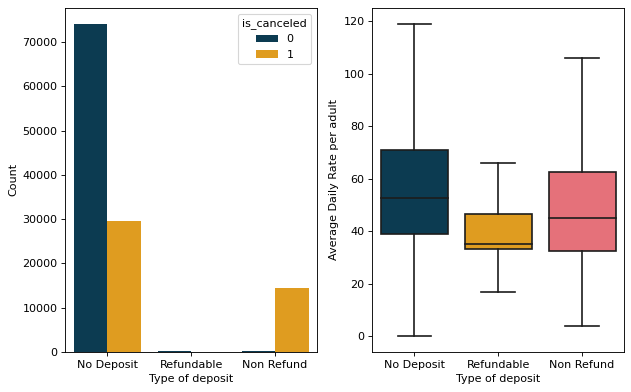

In [ ]:
# plotting two graphs side by side
fig, axes = plt.subplots(1,2)

# the first plot 
sns.countplot("deposit_type", hue="is_canceled", data=d,
        ax = axes[0]).set(xlabel = "Type of deposit", ylabel = "Count")

#calculate daily rate per adult
adr2 = d["adr"]/d["adults"]

# the second plot 
sns.boxplot("deposit_type",adr2,data=d,showfliers=False, 
        ax = axes[1]).set(xlabel = "Type of deposit", ylabel = "Average Daily Rate per adult")
plt.tight_layout()
plt.show()


#### 2.3.7 Examining the relationship between being on a waiting list and cancelled bookings

We next investigate the effect that a waiting list has on the probability of cancellation. This is where a booking is unable to be confirmed on request, and the customer must wait to see whether or not their needs can be fulfilled. We can see from the charts below that being on a waiting list significantly increases the chances of cancellation. This is probably due to the fact that during the waiting period, customers have time to make "back-up plans" and possibly get swayed by the prospect of another similar holiday that they can get confirmed right away. We don't consider the length of the wait to have any bearing, so once again we introduce a binary variable - did or did not wait.



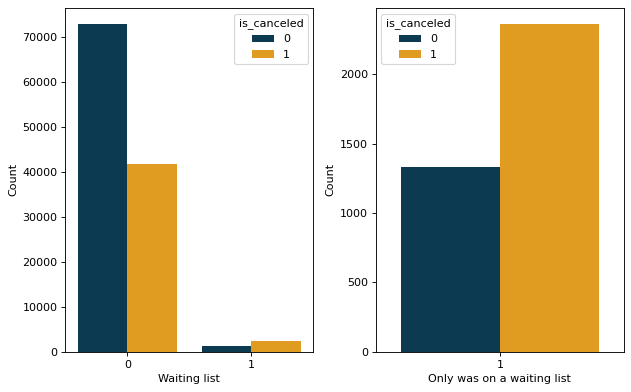

In [ ]:
# create a dummy variable 
d['had_to_wait'] = np.where((d["days_in_waiting_list"] > 0),1,0)

# plotting two graphs side by side
fig, axes = plt.subplots(1,2)

# the first plot 
sns.countplot('had_to_wait', hue="is_canceled",data=d,
        ax = axes[0]).set(xlabel = "Waiting list", ylabel = "Count")

# the second plot 
sns.countplot('had_to_wait', hue="is_canceled",data=d[d.had_to_wait == 1], 
        ax = axes[1]).set(xlabel = "Only was on a waiting list", ylabel = "Count")
plt.tight_layout()
plt.show()

#### 2.3.8 Examining the relationship between special requirements and cancelled bookings

Looking into how the number of special requirements requested as part of a booking, we decided to just consider the binary case i.e. did a booking have special requests or not. It didn't appear that the specific number of these requests had much of an impact. What was interesting though, is that a far higher proportion of customers without any requests cancelled than those who had made requests. This could be because people are more likely to make specific requests if they truly intend on taking the booking; if they intend on cancelling then this is just a waste of time. As a result we will consider this variable once transformed into a binary one, taking the value 1 if a booking contained special requests and 0 if not. As can be seen in the plots, people with requests cancel far less frequently than people who did not.  

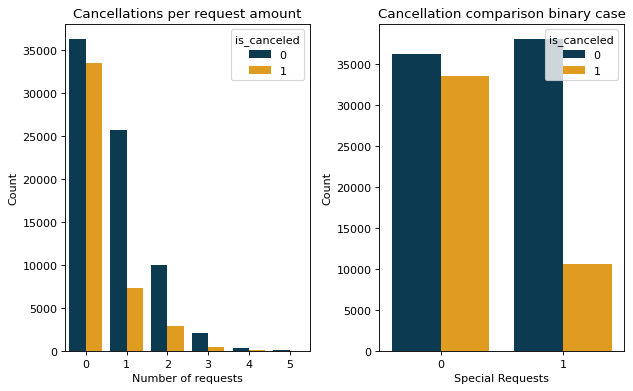

In [ ]:
# define a binary variable, which takes 1 for every nonzero entry for special requests
d["had_request"] = np.where((d.total_of_special_requests > 0),1,0)

# plotting two graphs side by side
fig, axes = plt.subplots(1,2)


# the first plot 
sns.countplot("total_of_special_requests",hue="is_canceled",data=d,
        ax = axes[0]).set(title = "Cancellations per request amount", xlabel = "Number of requests", ylabel = "Count")

# the second plot 
sns.countplot("had_request",hue="is_canceled",data=d, 
        ax = axes[1]).set(title = "Cancellation comparison binary case", xlabel = "Special Requests", ylabel = "Count")
plt.tight_layout()
plt.show()

#### 2.3.9 Examining the relationship between parking and cancelled bookings

Similarly to the special requests, the number of parking spaces requested could impact the probability of cancelling the booking. To analyse whether booking parking has an effect on the probability of cancelling the occurrences, firstly the number of occurrences were counted. Then, the cancellations per parking space request are visiualized. 

In [ ]:
#create a dummy dataframe which counts the nonzero entries for car parking spaces
parking_requests = d[(d.required_car_parking_spaces > 0)].count()
print("Number of people who booked one or more parking spaces: ", parking_requests['is_canceled'])

Number of people who booked one or more parking spaces:  7391


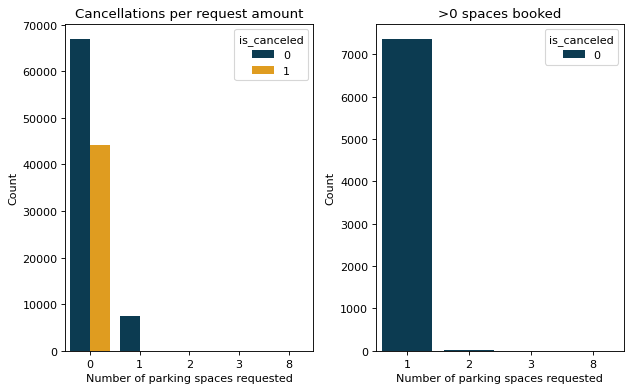

In [ ]:
# plotting two graphs side by side
fig, axes = plt.subplots(1,2)

# the first plot 
sns.countplot("required_car_parking_spaces",hue="is_canceled",data=d,
        ax = axes[0]).set(title = "Cancellations per request amount", xlabel = "Number of parking spaces requested", ylabel = "Count")

# the second plot 
sns.countplot("required_car_parking_spaces",hue="is_canceled",data=d[d.required_car_parking_spaces > 0], 
        ax = axes[1]).set(title = ">0 spaces booked", xlabel = "Number of parking spaces requested", ylabel = "Count")
plt.tight_layout()
plt.show()

From the bar chart it looks like nobody who booked a parking space cancelled. This can be confirmed with a count:

In [ ]:
# create a dummy dataframe which counts the amount of cancellations for the bookings that included >0 parking space requests
parking_and_cancellations = d[(d.required_car_parking_spaces > 0) & (d.is_canceled > 0)].count()
print("people who booked a parking space and cancelled: ", parking_and_cancellations['is_canceled'])

people who booked a parking space and cancelled:  0


This tells us that booking a parking space is a good indication that a customer is likely to honour their reservation and thus we will include required parking spaces as a variable for our model.

#### 2.3.10 Examining the relationship between market segment and cancelled bookings

One final variable of interest is the market segment. We see from the bar charts below that the segment "groups" has a significantly different distribution of cancellations to any other. Bookings from that segment are more frequently cancelled than not, whilst in every other segment the opposite is true. For the other segments, the probability of cancellations does still vary a fair bit, for example, cancellation in the "Online TA" segment, seems far more likely than in the "Direct" segment. As a result, it seems that market segment will be useful for our modelling so we will retain it for that purpose.

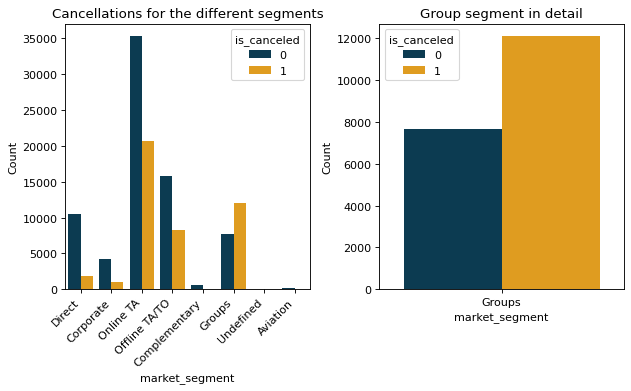

In [ ]:
# plotting two graphs side by side
fig, axes = plt.subplots(1,2)

# the first plot 
sns.countplot("market_segment",hue="is_canceled", data=d,
        ax = axes[0]).set(title = "Cancellations for the different segments", ylabel = "Count")
plt.setp(axes[0].get_xticklabels(), ha="right", rotation=45)
axes[0].legend(title="is_canceled", loc="upper right")

# the second plot 
sns.countplot("market_segment",hue="is_canceled", data=d[d.market_segment == "Groups"], 
        ax = axes[1]).set(title = "Group segment in detail", ylabel = "Count")

plt.tight_layout()
plt.show()

#### 2.3.11 Other features

Having looked into all other features we decided that nothing else was strongly enough related to the probability of a booking being cancelled to significantly improve our model. Model simplicity is an important factor to consider and we were wary of including anything that wouldn't provide any real predictive power, thus we have settled on the variables detailed above only. 

Please note that in the supplying notebook we have provided a detailed analysis of all other features and the reasoning why we believe they have limited predictive power.

#### 2.3.11 Examining the relationship between children and babies on a reservation and cancelled bookings

We observe that the number of reservations including babies or children is 9335. This makes up only 7.819% of total number of reservations.

9335
7.888%


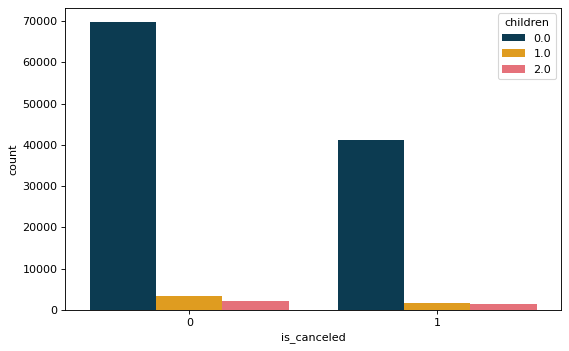

In [ ]:
# Load data
d2 = pd.read_csv("hotel.csv")

# number of reservations with children or babies
res_with_kids = d2[d2["children"] > 0]["children"].count() + d2[d2["babies"] > 0]["babies"].count() - d2[(d2["children"] > 0) & d2["babies"] > 0]["children"].count()
print(res_with_kids)

# what percentage of reservations contains children or babies?
print("{:.3%}".format(res_with_kids/len(d)))

sns.countplot("is_canceled", hue="children", data=d2[d2.children < 3])
plt.show()

#### 2.3.12 Examining the relationship between the number of adults on the reservation and cancelled bookings

We note that reservations for families/groups/business meetings (more than four adults) only happened few times and all were cancelled. 

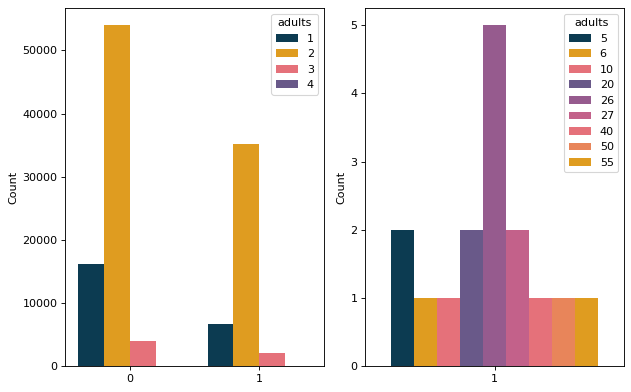

In [ ]:
# plotting two graphs side by side
fig, axes = plt.subplots(1,2)

# the first plot represents ...
sns.countplot("is_canceled",hue="adults",data=d[d.adults < 5],
        ax = axes[0]).set(title = "", xlabel = "", ylabel = "Count")

# the second plot compares ...
sns.countplot("is_canceled",hue="adults",data=d[d.adults >= 5], 
        ax = axes[1]).set(title = "", xlabel = "", ylabel = "Count")

plt.tight_layout()
plt.show()

#### 2.3.13 Examining the relationship between hotel type and cancelled bookings

More booking made for the City Hotel as well as more bookings cancelled.

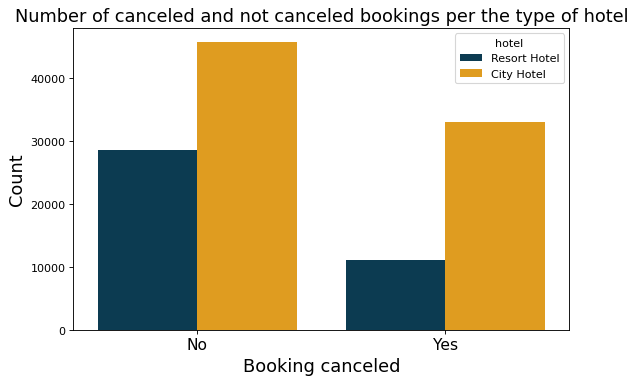

In [ ]:
sns.countplot("is_canceled",hue="hotel",data=d)
plt.title("Number of canceled and not canceled bookings per the type of hotel", fontsize = 16)
plt.xlabel("Booking canceled", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(ticks = [0,1], labels = ["No", "Yes"], fontsize = 14)
plt.show()

#### 2.3.14 Examining the relationship between Average Daily Rate and cancelled bookings

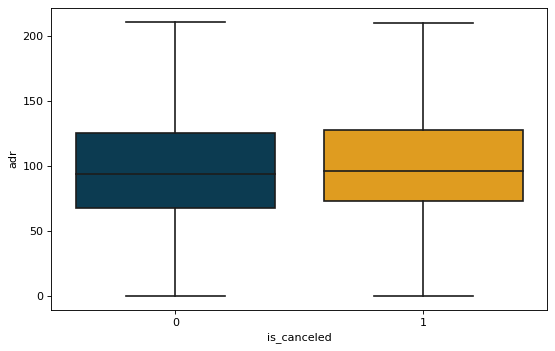

In [ ]:
sns.boxplot("is_canceled","adr",data=d,showfliers=False)
plt.show()

#### 2.3.15 Examining the relationship between guests being assigned their reserved room and cancelled bookings

Guests were assigned the room they did not reserve 14917 times. Vast majority of the guests who did not get their reserved room did not cancel.

reserved room different from assigned one happened:  14422  times


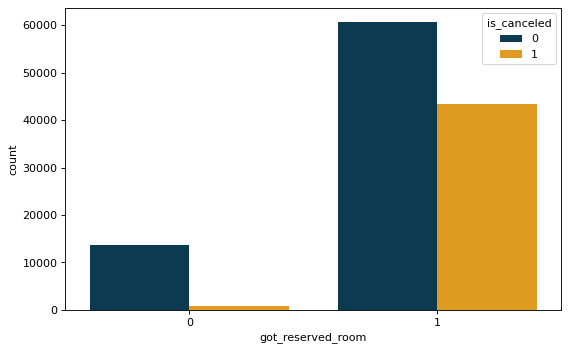

In [ ]:
print("reserved room different from assigned one happened: ", d[d.reserved_room_type != d.assigned_room_type]["reserved_room_type"].count(), " times")

# create a dummy variable
d["got_reserved_room"] = np.where(d["reserved_room_type"]==d["assigned_room_type"],1,0)

# plot
sns.countplot("got_reserved_room",hue="is_canceled",data=d)
plt.show()

#### 2.3.16 Examining the relationship between date of arrival and cancelled bookings

We note that the most arrivals were over summer months. However, there is no obvious trend for cancellations.

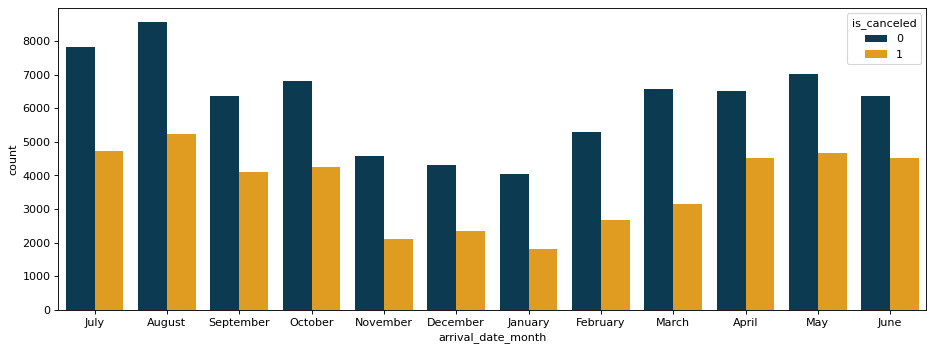

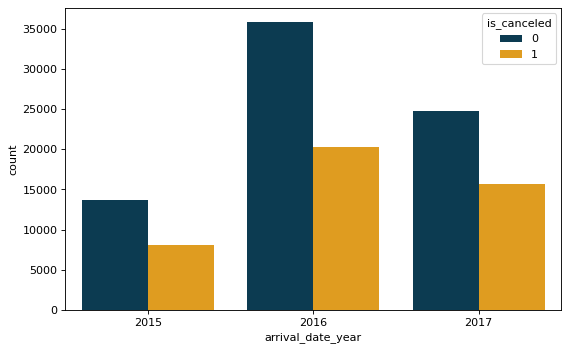

In [ ]:
plt.figure(figsize=(14,5))
sns.countplot(x = "arrival_date_month", hue = "is_canceled", data = d)
plt.show()

sns.countplot(x = "arrival_date_year", hue = "is_canceled", data = d)
plt.show()

#### 2.3.17 Examining the effect of using an agent and cancelled bookings

There are 334 different agents in total and many customers did not use an agent. Therefore, we decided to analyse wheteher using an agent or not effect the cancellations. Out of guests who used the agents majority did not cancel their bookings. However, we have identified agents that are connected to higher chance of cancellation. As can be seen from the graph below, the ratio of cancellations vs. non-cancellations is not significantly different and therefore we excluded the agents from the model.

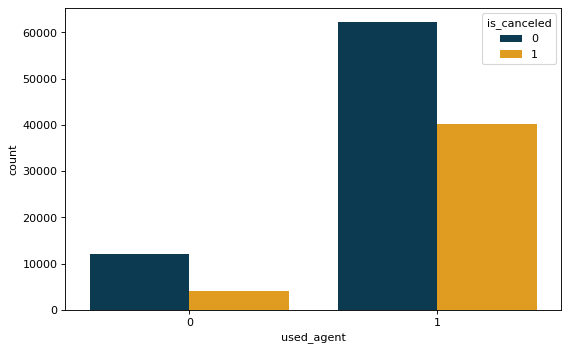

In [ ]:
# create a dummy variable
d['used_agent'] = np.where((d["agent"] != "Not Applicable"),1,0)
sns.countplot("used_agent",hue="is_canceled",data=d)
plt.show()


In [ ]:
# find top five agents whose clients have canceled bookings the most
d[d.is_canceled == 1].groupby("agent")["is_canceled"].value_counts().groupby(level=0).head().sort_values(ascending=False).nlargest(5).to_frame("counts").reset_index()

,agent,is_canceled,counts
0,9.0,1,13184
1,240.0,1,5481
2,1.0,1,5279
3,Not Applicable,1,4003
4,6.0,1,1025


#### 2.3.18 Examining the relationship between distribution channel and cancelled bookings

The cancelations per distribution channel were visualised with the cat plot below. This variable does not appear to split the cancelations from the non-cancelations for any channel.

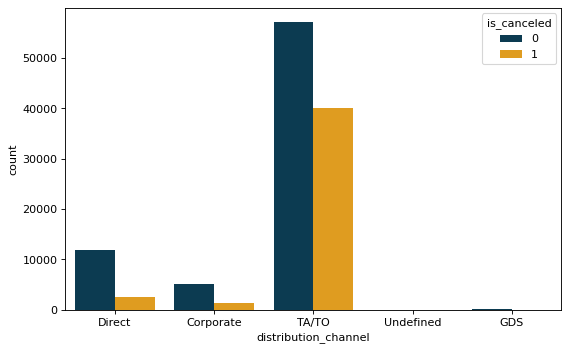

In [ ]:
sns.countplot("distribution_channel",hue="is_canceled",data=d)
plt.show()

#### 2.3.19 Examining the relationship between types of customers and cancelled bookings

The cancelations per distribution channel were visualised with the cat plot below. This variable does not appear to split the cancelations from the non-cancelations. 

% Transient Cancellers 0.41007
% Contract Cancellers 0.31122
% Transient-Party Cancellers 0.25516
% Group Cancellers 0.10211


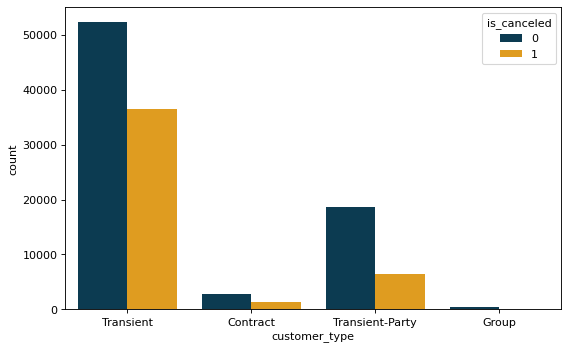

In [ ]:
#for each customer type the amount of customers of that type who cancelled are divided by the total amount of customers in that class
#to calculate the percentage of customers of that type who cancelled
print("% Transient Cancellers", round(d[(d.customer_type == "Transient") & (d.is_canceled == 1)]["customer_type"].count()
/d[(d.customer_type == "Transient")]["customer_type"].count(), 5))

print("% Contract Cancellers", round(d[(d.customer_type == "Contract") & (d.is_canceled == 1)]["customer_type"].count()
/d[(d.customer_type == "Contract")]["customer_type"].count(), 5))

print("% Transient-Party Cancellers", round(d[(d.customer_type == "Transient-Party") & (d.is_canceled == 1)]["customer_type"].count()
/d[(d.customer_type == "Transient-Party")]["customer_type"].count(), 5))

print("% Group Cancellers", round(d[(d.customer_type == "Group") & (d.is_canceled == 1)]["customer_type"].count()
/d[(d.customer_type == "Group")]["customer_type"].count(), 5))

sns.countplot("customer_type",hue="is_canceled",data=d)
plt.show()

#### 2.3.20 Examining the effect of staying for weekday or weekend nights and cancelled bookings

There are no obvious patterns in the data other than that when a stay is for 2-3 days it is more likely to be cancelled. This could be due to the fact that guests who visit the hotel for one night might be business professionals or people who are on their journey. Staying for 2-3 days is more connected to couple getaway or family weekend fun and could therefore be more likely to be cancelled. 

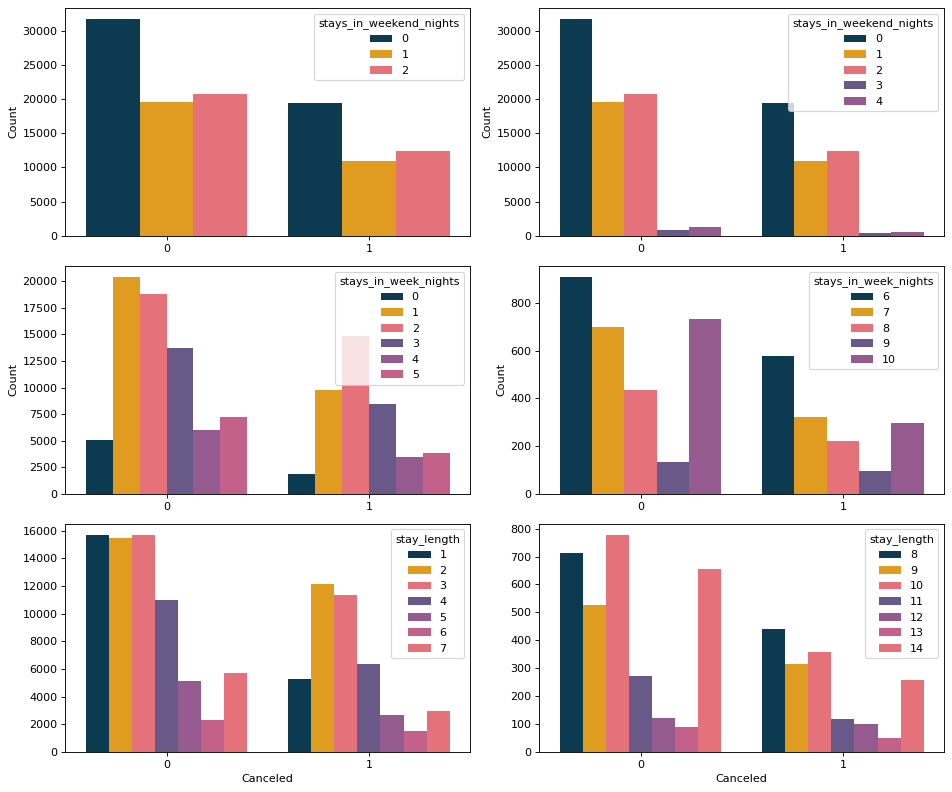

In [ ]:
# create a dummy variable
d["stay_length"] = d.stays_in_weekend_nights + d.stays_in_week_nights

# drop data were the length of stay is zero nights
d.drop(d[d.stay_length == 0].index, inplace = True)

# plotting two graphs side by side
fig, axes = plt.subplots(3,2, figsize = (12,10))

# the first plot 
sns.countplot("is_canceled",hue="stays_in_weekend_nights",data=d[d.stays_in_weekend_nights < 3],
        ax = axes[0,0]).set(title = "", xlabel = "", ylabel = "Count")

# the second plot 
sns.countplot("is_canceled",hue="stays_in_weekend_nights",data=d[d.stays_in_weekend_nights < 5], 
        ax = axes[0,1]).set(title = "", xlabel = "", ylabel = "Count")

# the third plot 
sns.countplot("is_canceled",hue="stays_in_week_nights",data=d[d.stays_in_week_nights < 6],
        ax = axes[1,0]).set(title = "", xlabel = "", ylabel = "Count")
axes[1,0].legend(title="stays_in_week_nights", loc="upper right")

# the fourth plot 
sns.countplot("is_canceled",hue="stays_in_week_nights",data=d[(d.stays_in_week_nights >= 6 ) & (d.stays_in_week_nights < 11)], 
        ax = axes[1,1]).set(title = "", xlabel = "", ylabel = "Count")

# the fifth plot 
sns.countplot("is_canceled",hue="stay_length",data=d[d.stay_length <= 7],
        ax = axes[2,0]).set(title = "", xlabel = "Canceled", ylabel = "")

# the sixth plot
sns.countplot("is_canceled",hue="stay_length",data=d[(d.stay_length > 7) & (d.stay_length <= 14)],
        ax = axes[2,1]).set(title = "", xlabel = "Canceled", ylabel = "")
plt.tight_layout()
plt.show()

### 2.4 Choosing the features for the modelling stage

After analyzing all features we have identified those which we believe will prove to be important for the modelling stage. We have decided to use 10 features (plus one outcome variable) and dropped the others for reasons outlined in the previous subsection. The full list of features is represented below:

1. is_canceled (the response variable)
2. is_portugal: binary, 1 if the reservation was made from Portugal, 0 otherwise
3. lead_time: continuous, the number of days that elapsed between the booking and arrival
4. market_segment: one-hot encoded, market segment designation
6. deposit_type: one-hot encoded, type of deposit the client made
7. required_car_parking_space: binary, 1 if the client required the parking space, 0 otherwise
8. full_board: binary, 1 if the client chose the full board option, 0 otherwise
9. previous: binary, 1 if the client has previously cancelled their reservation, 0 otherwise
10. previously_booked: binary, 1 if the client has previously made a booking and did not cancel it, 0 otherwise
11. had_to_wait: binary, 1 if the guest was put on the waiting list, 0 otherwise
12. had_request: binary, 1 if the guest had special requests, 0 otherwise

## 3. Model Fitting and Tuning

Explanatory data analysis enabled us to narrow the number of features to 10 as outlined in subsection 2.4. We considered several approaches when choosing how to build our model. Given the nature of our problem, we started off with a simple logistic regression model to use as a baseline to compare our more complex models to. We then explored some more complex avenues looking at both decision trees, and then further at random forests. Although both of these approaches led to slightly higher accuracy than our logistic regression model, they also saw a distinct increase in the false postive rate. In the context of the hotel industry this is problematic. Predicting that a booking is going to cancel when it actually isn't could result in a room becoming double booked. This would leave one set of customers without a room which could of course have significant legal consequences. In light of this, we decided to go with the simpler model, at the expense of a small amount of accuracy in order to ensure that the situation I have just described does not come to fruition. We will now explain the details of how we went about building this logistic regression model.

### 3.1 Splitting model into training and test

In [ ]:
# create a dataset used for modelling stage
d_model = d.drop(["adults", "adr", "arrival_date_year", "arrival_date_month", "arrival_date_day_of_month", "stays_in_week_nights", "total_of_special_requests",
"stays_in_weekend_nights", "distribution_channel", "customer_type", "stay_length", "hotel", "got_reserved_room", "arrival_date_week_number",
"meal", "assigned_room_type", "reserved_room_type", "previous_cancellations", "previous_bookings_not_canceled", "country", "agent", "used_agent",
 "is_repeated_guest", "booking_changes", "days_in_waiting_list"], axis = 1)

# define response variable and extract the explanatory features
y = d_model.is_canceled
X = pd.get_dummies(d_model.drop(["is_canceled"], axis = 1), drop_first = True)


# create training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 1)

### 3.2 Assessing model's performance: FPR, ROC and AUC 

When assessing the performance of the model we looked at various scores. 

False Positive Rate (FPR) is given by: 

$$
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}} 
$$

where FP is the number of false positive predictions and TN the number of true negative predictions. A false positive prediction means that a cancellation was predicted while in reality this booking was not cancelled. Conversely, a false negative means that a it was predicted that the booking would not to be cancelled while in reality it was. It is one of many measures of accuracy for models. In our example, the model will predict the most likely class for the booking based on the training data. The predicted label can then be checked against the actual label and thus, telling us the accuracy of the model. We want to emphasize the importance of false positive predictions in this case, since we wish to minimize the number of situations where the model predicts that the booking will be cancelled while in fact it is not. This scenario could lead to potential double booking and thus can be especially harmful for the hotel's reputation. 

Receiver operating characteristic (ROC) curve displays the false positive-false negative tradeoff for all possible thresholds. Using this metric allows us to visualize the performance of the model. The ideal ROC would be very close to the top left corner of the plot. 

Along with ROC curve we use Area Under Curve (AUC). It summarizes the quality of ROC metric. The ideal classification would score $\text{AUC} = 1$ and if we to choose the classes at random the area under the curve would be given by $\text{AUC} = 0.5$. AUC also equals to the probability that the classifier will rank a randomly chosen positive case (cancelled reservation) higher than a randomly chosen negative case (not cancelled booking).

### 3.3 Modelling approaches tried

#### 3.3.1 Logistic regression 

We first started with the logistic regression without regularization as a baseline model. The model performed reasonably well. In terms of training AUC the model scored $0.76$, the corresponding ROC has been ploted below. The overall performance is not great when compared to other models which scored higher in these two metrics. However, given the nature of the problem we are also interested in the false positive rate. When compared to other models it produces the least percentage of false positives which is important from hotel management point of view. Logistic regression also enables for better interpretability of results as it produces log odds given by:
$$
\textbf{log-odds} = \log \left( \frac{p(y=1|\textbf{x})}{p(y=0|\textbf{x})} \right)
$$

Given its advantages we have decided to continue with the logistic regression and optimize it using regularization. 

In [ ]:
# Logistic regression without penalty
m = LogisticRegression(penalty = 'none', fit_intercept = False, solver='lbfgs', max_iter=1000).fit(X_train, y_train)

In [ ]:
truth = pd.Categorical.from_codes(y_train, categories = ('not canceled','canceled'))
probs = m.predict_proba(X_train)[:,1]

In [ ]:
roc_calc = roc_curve(y_true=y_train, y_score=probs)

roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)

In [ ]:
def roc_plot(threshold=0.5):
    i = (np.abs(roc.threshold - threshold)).idxmin()

    sns.lineplot(x='false positive rate', y='true positive rate', data=roc, ci=None)

    plt.plot([0,1],[0,1], 'k--', alpha=0.5) # 0-1 line 
    plt.plot(roc.iloc[i,0], roc.iloc[i,1], 'r.')

    plt.title("threshold = %.2f" % threshold)
    plt.show()

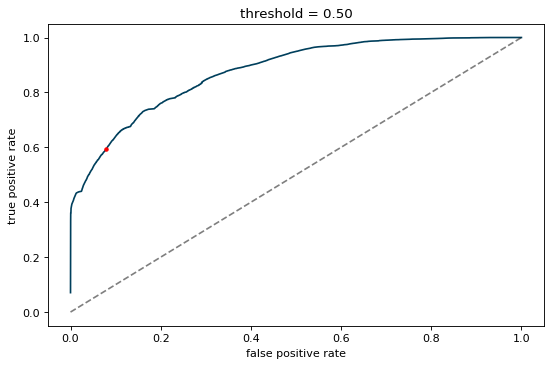

In [ ]:
roc_plot(threshold=0.5)

In [ ]:
sklearn.metrics.roc_auc_score(y_train, m.predict(X_train))

0.7571468837524803

In [ ]:
sklearn.metrics.confusion_matrix(y_train, m.predict(X_train))

array([[54607,  4714],
       [14361, 20990]])

Using the GridSearchCV we explored the effect of regularization on the baseline model. Note that we had to change the solver to "liblinear" for the regularization compared to "lbfgs" for models with no penalty. After applying penalization, model's performance improved to $0.88$ in terms of AUC. The score is comparable to performance of the decision tree and a bit lower than random forest. When looking at the Normalized Confusion Matrix, please note that the each row sums up to one. Hence, it is clear that we have, in fact, achieved to obtain a relatively small number of false positives (around 4% after having inspected the confusion matrix). However, when looking at the bottom row, we can see that the proportion is $0.41:0.59$. This means that the model performs poorly with classifying false negatives. Nevertheless, we believe that for hotel operations it is more important to prioritize the false positives as they are more costly and harmful for the management's reputation. 

In [ ]:
# Grid search for logistic regression

# Create first pipeline for base without reducing features
pipe = Pipeline([('classifier', LogisticRegression())])

# Create param grid
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
     'classifier__C' : np.logspace(-4, 4, 20),
     'classifier__solver' : ['liblinear']}
]

# Create grid search object and fit on data
best_clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, scoring = "roc_auc").fit(X_train, y_train)

In [ ]:
# print the best result
print(round(best_clf.best_score_,4))

0.8765


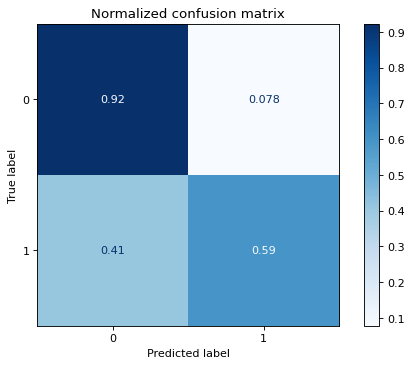

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(best_clf, X_train, y_train, 
                      normalize = "true",
                      cmap=plt.cm.Blues)
plt.title("Normalized confusion matrix")
plt.show()

After tuning the model, it is time to see how it performs on the test data. The results can be interpreted as in the model performs slighlty worse when comparing the AUC score. However, scores for both accuracy and precision are quite high. This and the fact that the model favours small amount of false positives as well as ease when it comes to interpreting the results allowed us to ensure that the model performs well with the task in mind.

In [ ]:
print("AUC_test_data: ", round(sklearn.metrics.roc_auc_score(y_test, best_clf.predict(X_test)), 5))
print("Accuracy_test_data: ", round(sklearn.metrics.accuracy_score(y_test, best_clf.predict(X_test)), 5))
print("Precision_test_data: ", round(sklearn.metrics.precision_score(y_test, best_clf.predict(X_test)), 5))

AUC_test_data:  0.7584
Accuracy_test_data:  0.80177
Precision_test_data:  0.82089


Finally, we provide the overview of the weights of different features. From the plot below we can see that if the clients engage with the hotel, make special requests including parking space, are from corporate and TA/TO or have previously booked a hotel room - they are less likely to cancel their reservation. Especially worth noting is the effect the request for parking space has. On contrary, when the deposit is non refundable, when country of origin is Portugal, when guest has previously cancelled or if the market segment is undefined or for travel agents - they are more likely to cancel. The rather counterintuitive effect of the non-refundable deposit remains puzzling to us. We would have to get some more data to be able to explain this phenomenon. Our best guess is that the deposit for some rooms is not that expensive relative to people's income and thus, people tend not to pay much attention to the sunk cost that the non-refundable deposit becomes.

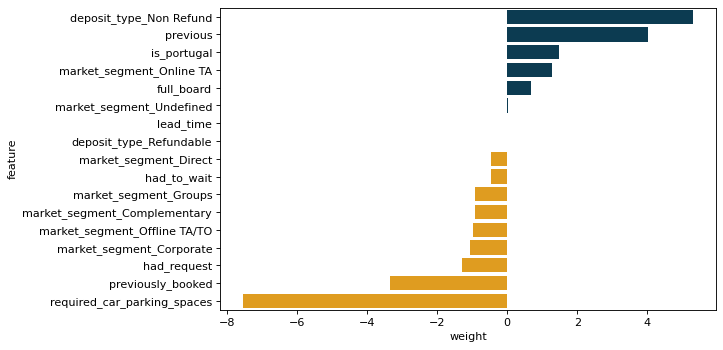

In [ ]:
weights = pd.DataFrame({"feature": X_train.columns, 
                        "weight": best_clf.best_estimator_.named_steps["classifier"].coef_[0]})

weights = weights.sort_values(by="weight", ascending=False)

specified = ['#003f5c' if x > 0 else '#ffa600' for x in weights["weight"]]
sns.barplot("weight", "feature", data = weights, palette = specified)
plt.show()

#### 3.3.2 Decision tree

Decision trees work by dividing up our data based on the values of certain features, in the hope that we can effectively separate the necessary classes in order to make predictions on the classes of future observations. In our case, we needed to tune our parameter "max_depth" which tells the algorithm how many layers of splitting to do. Using cross-validation we found this optimal value to be 13 and so we ran our model using this parameter. We achieved an accuracy of 0.80. Inspecting the resulting confusion matrix we see that 8.6% of non-cancellations were predicted to cancel (false positive rate).

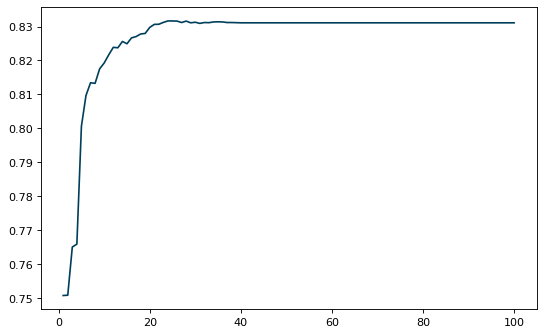

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

#optimise storage for accuracy values
acc = [0] * 100

#loop through depths 1 to 100 storing accuracy score for each
for i in range(1,101):
    clf=DecisionTreeClassifier(max_depth=i,random_state=1)
    clf=clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    acc[i-1]=metrics.accuracy_score(y_test,y_pred)

#plots accuracy v max_depth
plt.plot(range(1,101),acc)

#accuracy appears to peak around 27/28 and doesnt change a great deal beyond that so go with that to avoid overfitting

In [ ]:
#these functions are vaguely based on work in https://towardsdatascience.com/how-to-find-decision-tree-depth-via-cross-validation-2bf143f0f3d6

def treescv(X, y, tree_depths, cv=5, scoring='accuracy'):
    scores_list = []
    mean_list = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth,random_state=1)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        scores_list.append(cv_scores)
        mean_list.append(cv_scores.mean())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    mean_list = np.array(mean_list)
    accuracy_scores = np.array(accuracy_scores)
    return mean_list, accuracy_scores

def plotcv(depths, mean_list, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, mean_list, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths[::2])
    ax.legend()

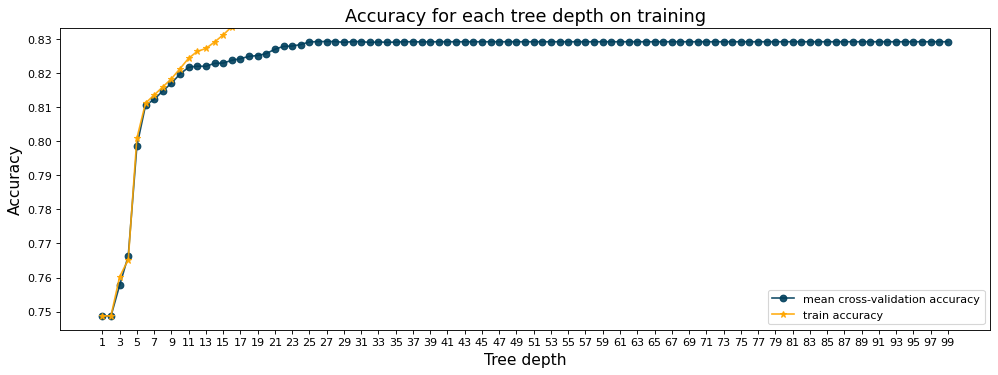

In [ ]:
our_depths = range(1,100)
mean_list, accuracy_scores = treescv(X_train,y_train,our_depths,cv=5)
plotcv(our_depths,mean_list=mean_list,accuracy_scores=accuracy_scores,title="Accuracy for each tree depth on training")

In [ ]:
#index of max mean accuracy 
index = mean_list.argmax()

#correlates index to max tree depth
optimal_depth = our_depths[index]

print("Best mean cross-validation accuracy at depth:",optimal_depth)

#anything beyond this doesn't yield an increase in accuracy but overfitting may be an issue

Best mean cross-validation accuracy at depth: 27


In [ ]:
dtmod=DecisionTreeClassifier(max_depth=optimal_depth,random_state=1)
dtmod=dtmod.fit(X_train,y_train)
y_pred=dtmod.predict(X_test)

metrics.confusion_matrix(y_test,y_pred)

array([[13410,  1518],
       [ 2478,  6263]])

In [ ]:
dt_prob = dtmod.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_true=y_test, y_score=dt_prob)

0.9018871830256765

In [ ]:
#set of parameters for grid search
grid_param = {
    'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
}
#carry out grid search
gs_rf = GridSearchCV(estimator=DecisionTreeClassifier(),
                    param_grid = grid_param,
                    scoring="accuracy",
                    cv=5)

#fits to training data
gs_rf.fit(X_train,y_train)

print(gs_rf.best_params_)

{'max_depth': 15}


#### 3.3.3 Random forest

To see if we could improve our decision tree model, we decided to expand to a random forest. Here we are fitting lots of different decision tress on unique subsets of the data and then combining them in the hope of getting a more accurate prediction. With random forests, maximum depth of each tree is not such a big problem as it is with an individual decision trees in terms of the likelihood of overfitting (https://towardsdatascience.com/random-forest-hyperparameters-and-how-to-fine-tune-them-17aee785ee0d). As such it is unnecessary to tune this parameter as we did for the decision tree model. We will just go with our optimal value of 27 from the tuning of our decision trees as this gave us an idea of what a reasonable value is. What is important, is the number of random features that we consider at each split and the criterion we use to make our splits. As such, we carried out a grid search over a range of these values to arrive at the optimal. We ended up considering the square root of the number of features at each split and splitting via the entropy criterion. This gave us an almost identical accuracy to the decision tree model, and a false positive rate of 11%.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#defines classifier
rfmod = RandomForestClassifier(max_features = "sqrt",random_state=1)

#fits classifier to training data
rfmod = rfmod.fit(X_train,y_train)

#generate predictions on test data
rf_pred = rfmod.predict(X_test)

#generate prediction probabilities
rf_probs = rfmod.predict_proba(X_test)[:,1]

#produce auc score
rf_auc = metrics.roc_auc_score(y_test,rf_probs)

print(rf_auc)

print(metrics.confusion_matrix(y_test,rf_pred))

0.9060592625481693
[[13376  1552]
 [ 2447  6294]]


In [ ]:
#set of parameters for grid search
grid_param = {
    'max_features': ["sqrt","log2",0.1,0.2,0.3,0.4,0.5],
    'criterion': ["gini","entropy"]
}

#carry out gridsearch
gs_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=1),
                    param_grid = grid_param,
                    scoring="accuracy",
                    cv=5)

gs_rf.fit(X_train,y_train)

print(gs_rf.best_params_)

{'criterion': 'entropy', 'max_features': 'sqrt'}


In [ ]:
print(gs_rf.best_params_)

{'criterion': 'entropy', 'max_features': 'sqrt'}


In [ ]:
#fits new model as above with optimised parameters
rfmod = RandomForestClassifier(criterion="entropy",max_features = "sqrt",max_depth=15,random_state=1)

rfmod = rfmod.fit(X_train,y_train)

rf_pred = rfmod.predict(X_test)

rf_probs = rfmod.predict_proba(X_test)[:,1]

roc_num = metrics.roc_auc_score(y_test,rf_probs)

roc_num

print(metrics.confusion_matrix(y_test,rf_pred))

print(metrics.accuracy_score(y_test,y_pred))

[[13217  1711]
 [ 2365  6376]]
0.8311715746334868


Confusion matrix, without normalization
[[13217  1711]
 [ 2365  6376]]
Normalized confusion matrix
[[0.88538317 0.11461683]
 [0.27056401 0.72943599]]


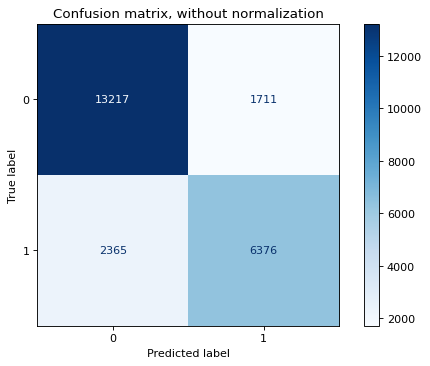

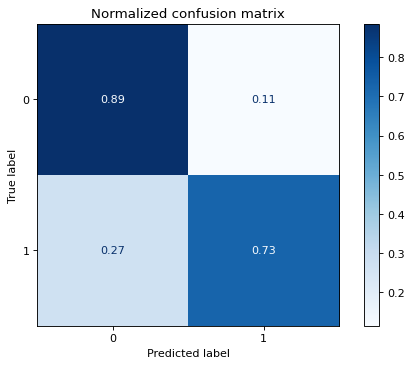

In [ ]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rfmod, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

#### 3.3.4 Other models

Another classification method we considered are Support Vector Machines. However, this method is not a good method for datasets with many features due to overfitting. As our data set has XX features, this method is less applicable for our task. Furthermore, Support Vector Machines are generally not a good method for datasets with many discrete or categorical features, which is another problem as barely any of our features contain continuous data. We tried to run a simple support vector machine model with a linear kernel to test the accuracy the model would produce. However, after 15+ minutes of running the model it still did not produce any output. Support vector machines are sensitive to the tuning of the hyperparameters. Doing a full gridsearch which finds the optimal kernel and optimal values for the parameters of the model would be very computationally expensive and take a long time to run. As this model needs a practical application for our task, a model with such a difficult setup is not viable and as argued will not produce a more accurate model anyway. Therefore, a Support Vector Machine model is no longer considered.

Another commonly used classifcation method is: Clustering. This is an unsupervised method. This method is intended to be used when there are no labels for the data. The goal of clustering is to find patterns or groupings in the data. In our case, we do have labels for the data: "is_canceled", which we are trying to predict. This makes clustering not applicable to our problem and we will therfore no longer consider it.



In [ ]:
from sklearn.svm import SVC

In [ ]:
# C = 1      # [1,5,10,50,100],
# degree = 2  # [2,3,4],
# kernel = 'linear' # ['poly', 'rbf', 'linear'])


# svc_model = SVC(kernel=kernel, degree=degree, C=C, gamma='scale').fit(X, y)

# svc_model.score(X, y)

## 4. Discussion & Conclusions


In this section we will be providing an overview of our model and how the results from it can be used to help the hotel operator learn more about their cancellations. The hope is that this information can help with planning to avoid empty beds.

#### 4.1 Model Overview

As detailed above, we decided to go with a logistic regression model. Despite this being slightly less accurate overall than some of the other methods we explored, it did give us the lowest false positive rate. This is particularly imporant in a situation such as this as double-booking rooms and having both groups arriving at the same time is extremely problematic and needs to be avoided as much as possible. Looking back at the overview of our model coefficients from the previous part, we can see that lead time didn't appear to have much of an effect on predicting a cancellation. In hindsight, it may have been beneficial to omit it from our model altogether. Apart from this, all other variables we explored seemed to have some sort of effect.

#### 4.2 Implications

Looking at the magnitudes of each coefficient in the aforementioned coefficient graph, we can see that in terms of predicting a cancellation, someone having a non-refundable deposit is a heavy indication that they would cancel. As we have previously said, this seems a bit counter-intuitive given that a logical person would surely not cancel a booking with a non-refundable deposit, however we can only make conclusions based on the data we have available. Going forward, it may be beneficial to collect further data to verify this strange correlation, or even survey the individuals responsible for these cancellations to get a better idea of why this is the case. All the other variables with a positive effect on likelihood of cancellation all make logical sense. These include having a history of cancellations, booking through undefined or online TA market segements, being from Portugal and being on a full board meal plan. There is also a very small positive impact of having a refundable deposit. 

On the other hand, our model also reveals a number of variables which are indicative of a booking which is unlikely to be cancelled. By far the variable with the largest effect in this regard is if a parking space has been booked. Previous bookings which haven't been cancelled are also a strong indication that someone is unlikely to cancel. There are also a number of variables with a much smaller effect, including all other market segments, if a booking has any special requests and if they were on a waiting list. The fact that being on a waiting list decreases the chances of cancellation according to our model seems strange given what we observed in our EDA, and this is something that, given more time, would be looked into further.

#### 4.3 Conclusion

To sum up, we believe that out model can be considered an effective tool for predicting reservations likely to be cancelled. Hotel management can try to use our results to create a strategy aimed at reducing lost profit due to cancellations. Our model aimes to minimize the number of false positives, however if it happens that the hotel has resold the room - the management can try to implement a set of promotional acitvities (e.g. free upgrade to a better room ) aimed at reducing the harmful effect it would have on hotel management's reputation. We believe that our report ensures a better understanding of cancellations and can be used as a guidebook for deriving an optimal booking strategy to prevent double bookings as well as room being empty. To our contention, it is likely that our model will help the management to gain the competitive advantage and optimize their operations.

## 5. References 

Antonio, N., Ana de Almeida and Luís Nunes. “Hotel booking demand datasets.” Data in Brief 22 (2019): 41 - 49.

## 6. Convert Document

In [ ]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf proj2.ipynb

[NbConvertApp] Converting notebook proj2.ipynb to pdf
[NbConvertApp] Support files will be in proj2_files/
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Maki

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=054e0e2b-82d3-4240-bb5e-2eca39c83efa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>